# Dynamic Models



### Preliminaries

- Goal 
  - Introduction to dynamic (=temporal) Latent Variable Models, including the Hidden Markov Model and Kalman filter.   
- Materials
  - Mandatory
    - These lecture notes
  - Optional 
    - Bishop pp.605-615 on Hidden Markov Models
    - Bishop pp.635-641 on Kalman filters
    - Faragher (2012), [Understanding the Basis of the Kalman Filter](https://github.com/bertdv/BMLIP/blob/master/lessons/notebooks/files/Faragher-2012-Understanding-the-Basis-of-the-Kalman-Filter.pdf)
    - Minka (1999), [From Hidden Markov Models to Linear Dynamical Systems](https://github.com/bertdv/BMLIP/blob/master/lessons/notebooks/files/Minka-1999-from-HMM-to-LDS.pdf)
      

### Example Problem

- We consider a one-dimensional cart position tracking problem, see [Faragher (2012)](https://github.com/bertdv/BMLIP/blob/master/lessons/notebooks/files/Faragher-2012-Understanding-the-Basis-of-the-Kalman-Filter.pdf).  

- The hidden states are the position $z_t$ and velocity $\dot z_t$. We can apply an external acceleration/breaking force $u_t$. (Noisy) observations are represented by $x_t$. 

- The equations of motions are given by

$$\begin{align*}
\begin{bmatrix} z_t \\ \dot{z_t}\end{bmatrix} &=  \begin{bmatrix} 1 & \Delta t \\ 0 & 1\end{bmatrix} \begin{bmatrix} z_{t-1} \\ \dot z_{t-1}\end{bmatrix} + \begin{bmatrix} (\Delta t)^2/2 \\ \Delta t\end{bmatrix} u_t + \mathcal{N}(0,\Sigma_z) \\
x_t &= \begin{bmatrix} z_t \\ \dot{z_t}\end{bmatrix} + \mathcal{N}(0,\Sigma_x) 
\end{align*}$$

- Task: Infer the position $z_t$ after 10 time steps. (Solution later in this lesson).

<p style="text-align:center;"><img src="./figures/Faragher-2012-cart-1.png" width="600px"><p style="text-align:center;">


### Dynamical Models

- In this lesson, we consider models where the sequence order of observations matters. 

- Consider the _ordered_ observation sequence $x^T \triangleq \left(x_1,x_2,\ldots,x_T\right)$.
  - (For brevity, in this lesson we use the notation $x_t^T$ to denote $(x_t,x_{t+1},\ldots,x_T)$ and drop the subscript if $t=1$, so $x^T = x_1^T = \left(x_1,x_2,\ldots,x_T\right)$).

- We wish to develop a generative model
    $$ p( x^T )$$
that 'explains' the time series $x^T$. 

- We cannot use the IID assumption $p( x^T ) = \prod_t p(x_t )$ for a time series, since consecutive observations may have statistical dependencies. In general, we can _always_ use the **chain rule** (a.k.a. **the general product rule**)

$$\begin{align*}
p(x^T) &= p(x_T|x^{T-1}) \,p(x^{T-1}) \\
  &=  p(x_T|x^{T-1}) \,p(x_{T-1}|x^{T-2}) \cdots p(x_2|x_1)\,p(x_1) \\
  &= p(x_1)\prod_{t=2}^T p(x_t\,|\,x^{t-1})
\end{align*}$$
which is true for any model $p(x^T)$.

- Generally, we will want to limit the depth of dependencies on previous observations. For example, a $K$-th order linear **Auto-Regressive** (AR) model is given by
$$\begin{align*}
  p(x_t\,|\,x^{t-1}) = \mathcal{N}\left(x_t \,\middle|\,  \sum_{k=1}^K a_k x_{t-k}\,,\sigma^2\,\right)  
\end{align*}$$
limits the dependencies to the past $K$ samples.

### State-space Models

- A limitation of AR models is that they need a lot of parameters in order to create a flexible model. E.g., if $x_t \in \mathbb{R}^M$ is an $M$-dimensional time series, then the $K$-th order AR model for $x_t$ will have $KM^2$ parameters. 

- Similar to our work on Gaussian Mixture models, we can create a flexible dynamic system by introducing _latent_ (unobserved) variables  $z^T \triangleq \left(z_1,z_2,\dots,z_T\right)$ (one $z_t$ for each observation $x_t$). In dynamic systems, observation-dependent latent variables $z_t$ are called _state variables_.

- A **state space model** is a particular latent variable dynamical model defined by
$$\begin{align*}
 p(x^T,z^T) &= \underbrace{p(z_1)}_{\text{initial state}} \prod_{t=2}^T \underbrace{p(z_t\,|\,z_{t-1})}_{\text{state transitions}}\,\prod_{t=1}^T \underbrace{p(x_t\,|\,z_t)}_{\text{observations}}
\end{align*}$$
  - The condition $p(z_t\,|\,z^{t-1}) = p(z_t\,|\,z_{t-1})$ is called a $1$-st order Markov condition.

<!--- - In a Markovian state-space model, the observation sequence $x^T$ is not a first-order Markov chain, i.e., for the state-space model
    $$\begin{align*}
 p(x^T,z^T) &= p(z_1) \prod_{t=2}^T p(z_t\,|\,z_{t-1})\,\prod_{t=1}^T p(x_t\,|\,z_t)
\end{align*}$$
the following statement holds: 
    $$p(x_t\,|\,x_{t-1},x_{t-2}) \neq p(x_t\,|\,x_{t-1})\,.$$
In other words, the latent variables $z_t$ represent a memory bank for past observations beyond $t-1$. (Proof as exercise). 
--->

- The Forney-style factor graph for a state-space model:

<p style="text-align:center;"><img src="./figures/ffg-state-space.png" width="600px"></p>

### Hidden Markov Models and Linear Dynamical Systems

- A **Hidden Markov Model** (HMM) is a specific state-space model with <span class="emphasis">discrete-valued</span> state variables $z_t$.

- Typically, $z_t$ is a $K$-dimensional one-hot coded latent 'class indicator' with transition probabilities $a_{jk} \triangleq p(z_{tk}=1\,|\,z_{t-1,j}=1)$, or equivalently,
  $$p(z_t|z_{t-1}) = \prod_{k=1}^K \prod_{j=1}^K a_{jk}^{z_{t-1,j}\cdot z_{tk}}$$
which is usually accompanied by an initial state distribution $p(z_{1k}=1) = \pi_k$.

  
- The classical HMM has also discrete-valued observations but in pratice any (probabilistic) observation model $p(x_t|z_t)$ may be coupled to the hidden Markov chain. 

<!---
- The following figure shows the typical trellis structure of the many possible state transitions paths.   
<img src="./figures/Figure13.7.png" width="400px">
--->

- Another well-known state-space model with <span class="emphasis">continuous-valued</span> state variables $z_t$ is the **(Linear) Gaussian Dynamical System** (LGDS), which is defined as

$$\begin{align*}
p(z_t\,|\,z_{t-1}) &= \mathcal{N}\left(z_t \,|\, A z_{t-1},\,\Sigma_z\right) \\ 
p(x_t\,|\,z_t) &= \mathcal{N}\left(x_t\,|\, C z_t,\,\Sigma_x\right) \\
p(z_1) &= \mathcal{N}\left(z_1\,|\, \mu_1,\,\Sigma_1\right)
\end{align*}$$
<!---or, equivalently (in the usual state-space notation)
$$\begin{align*}
z_k &= A z_{k-1} + \mathcal{N}\left(0,\Sigma_z \right) \\ 
x_k &= C z_k + \mathcal{N}\left( 0, \Sigma_x \right) \\
z_1 &= \mu_1 + \mathcal{N}\left( 0, \Sigma_1\right)
\end{align*}$$
--->

- Note that the joint distribution over all states and observations $\{(x_1,z_1),\ldots,(x_t,z_t)\}$ is a (large-dimensional) Gaussian distribution. This means that, in principle, every inference problem on the LGDS model also leads to a Gaussian distribution.

- HMM's and LGDS's (and variants thereof) are at the basis of a wide range of complex information processing systems, such as speech and language recognition, robotics and automatic car navigation, and even processing of DNA sequences.  

### Common Signal Processing Tasks as Message Passing-based Inference

- As we have seen, inference tasks in linear Gaussian state space models can be analytically solved.

- However, these derivations quickly become cumbersome and prone to errors.

- Alternatively, we could specify the generative model in a (Forney-style) factor graph and use automated message passing to infer the posterior over the hidden variables. Here follows some examples.

- **Filtering**, a.k.a. state estimation: estimation of a state (at time step $t$), based on past and current (at $t$) observations. 
<p style="text-align:center;"><img src="./figures/ffg-state-space-filtering.png" width="600px"></p>

- **Smoothing**: estimation of a state based on both past and future observations. Needs backward messages from the future.  

<p style="text-align:center;"><img src="./figures/ffg-state-space-smoothing.png" width="600px"></p>

- **Prediction**: estimation of future state or observation based only on observations of the past.

<p style="text-align:center;"><img src="./figures/ffg-state-space-prediction.png" width="600px"></p>


### An Analitical Derivation of the <a id='kalman-filter'>Kalman Filter</a>


 
- Let's work out the Kalman filter for a scalar linear Gaussian dynamical system:
$$\begin{aligned}
    p(z_t\,|\,z_{t-1}) &= \mathcal{N}(z_t\,|\,a z_{t-1},\sigma_z^2) \qquad &&\text{(state transition)}   \\
    p(x_t\,|\,z_t) &= \mathcal{N}(x_t\,|\,c z_t,\sigma_x^2) \qquad &&\text{(observation)}     
\end{aligned}$$


- Technically, a [**Kalman filter**](https://en.wikipedia.org/wiki/Kalman_filter) is the solution to the recursive estimation (inference) of the hidden state $z_t$ based on past observations in an LGDS, i.e., Kalman filtering solves the problem $p(z_t\,|\,x^t)$ based on the previous state estimate $p(z_{t-1}\,|\,x^{t-1})$ (the "prior") and a new observation $x_t$  (in the context of the given model specification of course). 
 


- In Bayesian terms, a Kalman filter computes
$$\begin{align*}
\overbrace{p(z_t\,|\,x^t)}^{\text{posterior}} &\cdot \overbrace{p(x_t\,|\,x^{t-1})}^{\text{evidence}} = p(x_t,z_t\,|\,x^{t-1})  \\
 &= p(x_t\,|\,z_t) \cdot p(z_t\,|\,x^{t-1})  \\
 &= p(x_t\,|\,z_t) \, \int p(z_t,z_{t-1}\,|\,x^{t-1}) \mathrm{d}z_{t-1}   \\
 &= \underbrace{p(x_t\,|\,z_t)}_{\text{likelihood}} \, \int \underbrace{p(z_t\,|\,z_{t-1})}_{\text{state transition}} \, \underbrace{p(z_{t-1}\,|\,x^{t-1})}_{\text{prior}} \mathrm{d}z_{t-1}  \\
 &= \mathcal{N}(x_t|c z_t, \sigma_x^2) \, \int \mathcal{N}(z_t\,|\,a z_{t-1},\sigma_z^2) \, \mathcal{N}(z_{t-1} \,|\, \mu_{t-1}, \sigma_{t-1}^2)  \mathrm{d}z_{t-1} \qquad \text{(KF-1)}
 \end{align*} $$
where we assumed that the previous state estimate is given by
$$\begin{align*} 
p(z_{t-1}\,|\,x^{t-1}) = \mathcal{N}(z_{t-1} \,|\, \mu_{t-1}, \sigma_{t-1}^2) \qquad \text{(prior)}
\end{align*}$$ 


- The result (Eq. FK-1) can be further worked out to analytical updates for the evidence and posterior. In the following, we often run into Gaussians of the form $\mathcal{N}(x\,|\,cz,\sigma^2)$ that we need to rewrite as an argument of $z$. We wil use the following "mean transformation" equality:
 $$\mathcal{N}(x\,|\,cz,\sigma^2) = \frac{1}{c}\mathcal{N}\left(z \,\middle|\,\frac{x}{c},\left(\frac{\sigma}{c}\right)^2\right)\,.$$



- Let's further work out the Kalman filter, starting from Eq. KF-1: 
$$\begin{align*}
 \underbrace{\mathcal{N}(x_t|c z_t, \sigma_x^2)}_{\text{likelihood}} &\, \int \underbrace{\mathcal{N}(z_t\,|\,a z_{t-1},\sigma_z^2)}_{\substack{\text{state transition} \\ \text{(use mean transformation)}} } \, \underbrace{\mathcal{N}(z_{t-1} \,|\, \mu_{t-1}, \sigma_{t-1}^2) }_{\text{prior}}  \mathrm{d}z_{t-1} = \\
&= \mathcal{N}(x_t|c z_t, \sigma_x^2) \, \int \frac{1}{a}\underbrace{\mathcal{N}\left(z_{t-1}\bigm|  \frac{z_t}{a},\left(\frac{\sigma_z}{a}\right)^2 \right) \mathcal{N}(z_{t-1} \,|\, \mu_{t-1}, \sigma_{t-1}^2)}_{\text{use Gaussian multiplication formula SRG-6}} \mathrm{d}z_{t-1} \\
&= \frac{1}{a} \mathcal{N}(x_t|c z_t, \sigma_x^2) \, \int \underbrace{\mathcal{N}\left(\mu_{t-1}\bigm|  \frac{z_t}{a},\left(\frac{\sigma_z}{a}\right)^2 + \sigma_{t-1}^2 \right)}_{\text{not a function of }z_{t-1}} \underbrace{\mathcal{N}(z_{t-1} \,|\, \cdot, \cdot)}_{\text{integrates to }1} \mathrm{d}z_{t-1} \\
&= \frac{1}{a} \underbrace{\mathcal{N}(x_t|c z_t, \sigma_x^2)}_{\text{use mean transformation}} \, \underbrace{\mathcal{N}\left(\mu_{t-1}\bigm|  \frac{z_t}{a},\left(\frac{\sigma_z}{a}\right)^2 + \sigma_{t-1}^2 \right)}_{\text{use mean transformation}} \\
&= \frac{1}{c} \underbrace{\mathcal{N}\left(z_t \bigm|  \frac{x_t}{c}, \left( \frac{\sigma_x}{c}\right)^2 \right) \mathcal{N}\left(z_t\, \bigm|\,a \mu_{t-1},\sigma_z^2 + \left(a \sigma_{t-1}\right)^2 \right)}_{\text{use SRG-6 again}} \\
&= \underbrace{\frac{1}{c} \mathcal{N}\left( \frac{x_t}{c} \bigm| a \mu_{t-1}, \left( \frac{\sigma_x}{c}\right)^2+ \sigma_z^2 + \left(a \sigma_{t-1}\right)^2\right)}_{\text{use mean transformation}} \, \mathcal{N}\left( z_t \,|\, \mu_t, \sigma_t^2\right)\\
  &= \underbrace{\mathcal{N}\left(x_t \,|\, ca \mu_{t-1}, \sigma_x^2 + c^2(\sigma_z^2+a^2\sigma_{t-1}^2) \right)}_{\text{evidence } p(x_t|x^{t-1})} \cdot \underbrace{\mathcal{N}\left( z_t \,|\, \mu_t, \sigma_t^2\right)}_{\text{posterior }p(z_t|x^t) }
\end{align*}$$
with
$$\begin{align*}
  \rho_t^2 &= a^2 \sigma_{t-1}^2 + \sigma_z^2 \qquad &&\text{(predicted variance)}\\
  K_t &= \frac{c \rho_t^2}{c^2 \rho_t^2 + \sigma_x^2} \qquad &&\text{(Kalman gain)} \\
  \mu_t &= \underbrace{a \mu_{t-1}}_{\text{prior prediction}} + K_t \cdot \underbrace{\left( x_t - c a \mu_{t-1}\right)}_{\text{prediction error}} \qquad &&\text{(posterior mean)}\\
  \sigma_t^2 &= \left( 1 - c\cdot K_t \right) \rho_t^2 \qquad &&\text{(posterior variance)}
\end{align*}$$



- Kalman filtering consists of computing/updating these last four equations for each new observation ($x_t$). This is a very efficient recursive algorithm to estimate the state $z_t$ from all observations (until $t$). If needed you can also track the "instant" evidence as $$p(x_t|x^{t-1}) = \mathcal{N}\left(x_t \,|\, ca \mu_{t-1}, \sigma_x^2 + c^2(\sigma_z^2+a^2\sigma_{t-1}^2) \right)$$

- Note that, for observed $x^t$, the evidence $p(x_t|x^{t-1})$ is a scalar number that scores how well the model predicts $x^t$, based on past observations $x^{t-1}$.

- Exam guide: the above derivation of the Kalman filter is too long and error-prone to be asked at an exam. You should be able to follow the derivation in detail, but will not be requested to reproduce the full derivation without some guidance. The complexity of the derivation underlines why inference should be automated by a toolbox (like RxInfer).


### Multi-dimensional Kalman Filtering

- The Kalman filter equations can also be derived for multidimensional state-space models. In particular, for the model
$$\begin{align*}
z_t &= A z_{t-1} + \mathcal{N}(0,\Gamma) \\
x_t &= C z_t + \mathcal{N}(0,\Sigma)
\end{align*}$$
the Kalman filter update equations for the posterior $p(z_t |x^t) = \mathcal{N}\left(z_t \bigm| \mu_t, V_t \right)$ are given by (see Bishop, pg.639)
$$\begin{align*}
P_t &= A V_{t-1} A^T + \Gamma \qquad &&\text{(predicted variance)}\\
K_t &= P_t C^T \cdot \left(C P_t C^T  + \Sigma \right)^{-1} \qquad &&\text{(Kalman gain)} \\
\mu_t &= A \mu_{t-1} + K_t\cdot\left(x_t - C A \mu_{t-1} \right) \qquad &&\text{(posterior state mean)}\\
V_t &= \left(I-K_t C \right) P_{t}  \qquad &&\text{(posterior state variance)}
\end{align*}$$



### Code Example: Kalman Filtering and the Cart Position Tracking Example Revisited


- We can now solve the cart tracking problem of the introductory example by implementing the Kalman filter.

In [1]:
using Pkg; Pkg.activate("../."); Pkg.instantiate();
using IJulia; try IJulia.clear_output(); catch _ end

  Activating project at `~/github/bertdv/BMLIP/lessons`


Prediction: MvNormalMeanCovariance(
μ: 

[40.47695983128013, 4.566753952073259]
Σ: 

[1.2958787328575079 0.3921572953097835; 0.3921572953130242 0.3415636711134632]
)

Measurement: MvNormalMeanCovariance(
μ: [39.91366979838735, 1.1168146182558294]
Σ: [1.0 0.0; 0.0 2.0]
)

Posterior: MvNormalMeanCovariance(
μ: [39.90717068537177, 4.065688527593364]
Σ: [0.5516100293973586 0.15018972175285758; 0.15018972175409862 0.24143326063188655]
)



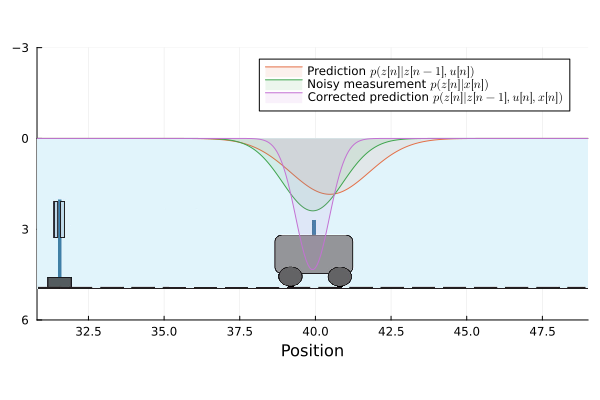

In [2]:
using RxInfer, LinearAlgebra, Plots

include("scripts/cart_tracking_helpers.jl")

# Specify the model parameters
Δt = 1.0                     # assume the time steps to be equal in size
A = [1.0 Δt;
     0.0 1.0]
b = [0.5*Δt^2; Δt] 
Σz = convert(Matrix,Diagonal([0.2*Δt; 0.1*Δt])) # process noise covariance
Σx = convert(Matrix,Diagonal([1.0; 2.0]))     # observation noise covariance;

# Generate noisy observations
n = 10                # perform 10 timesteps
z_start = [10.0; 2.0] # initial state
u = 0.2 * ones(n)     # constant input u
noisy_x = generateNoisyMeasurements(z_start, u, A, b, Σz, Σx);

m_z = noisy_x[1]                                    # initial predictive mean
V_z = A * (1e8*Diagonal(I,2) * A') + Σz             # initial predictive covariance

for t = 2:n
    global m_z, V_z, m_pred_z, V_pred_z
    #predict
    m_pred_z = A * m_z + b * u[t]                   # predictive mean
    V_pred_z = A * V_z * A' + Σz                    # predictive covariance
    #update
    gain = V_pred_z * inv(V_pred_z + Σx)            # Kalman gain
    m_z = m_pred_z + gain * (noisy_x[t] - m_pred_z) # posterior mean update
    V_z = (Diagonal(I,2)-gain)*V_pred_z             # posterior covariance update
end
println("Prediction: ",MvNormalMeanCovariance(m_pred_z,V_pred_z))
println("Measurement: ", MvNormalMeanCovariance(noisy_x[n],Σx))
println("Posterior: ", MvNormalMeanCovariance(m_z,V_z))
plotCartPrediction(m_pred_z[1], V_pred_z[1], m_z[1], V_z[1], noisy_x[n][1], Σx[1][1])

### The Cart Tracking Problem Revisited: Inference by Message Passing

- Let's solve the cart tracking problem by sum-product message passing in a factor graph like the one depicted above. All we have to do is create factor nodes for the state-transition model $p(z_t|z_{t-1})$ and the observation model $p(x_t|z_t)$. Then we let [RxInfer](https://biaslab.github.io/rxinfer-website/) execute the message passing schedule. 

In [3]:
@model function cart_tracking(n, A, b, Σz, Σx, z_prev_m_0, z_prev_v_0, u)
    
    # We create constvar references for better efficiency
    cA = constvar(A)
    cB = constvar(b)
    cΣz = constvar(Σz)
    cΣx = constvar(Σx)
    
    znodes = Vector{Any}(undef, n)
    # `z` is a sequence of hidden states
    z = randomvar(n)
    # `x` is a sequence of "clamped" observations
    x = datavar(Vector{Float64}, n)
    
    z_prior ~ MvNormalMeanCovariance(z_prev_m_0, z_prev_v_0)
    
    z_prev = z_prior
    
    for i in 1:n
        znodes[i],z[i] ~ MvNormalMeanCovariance(cA * z_prev + cB*u[i], cΣz)
        x[i] ~ MvNormalMeanCovariance(z[i], cΣx)
        z_prev = z[i]
    end
    
    return z, x, znodes
end

Now that we've built the model, we can perform Kalman filtering by inserting measurement data into the model and performing message passing.

Prediction: MvNormalMeanCovariance(
μ: [40.39871176657166, 4.554188717242919]
Σ: [1.2934227334046857 0.3916229823498387; 0.3916229823498387 0.3414332606222485]
)

Measurement: MvNormalMeanCovariance(
μ: [39.91366979838735, 1.1168146182558294]
Σ: [1.0 0.0; 0.0 2.0]
)

Posterior: MvNormalMeanCovariance(
μ: [39.87332470472364, 4.066438870175068]
Σ: [0.551150997075792 0.1501469959500068; 0.1501469959500068 0.24141815274489328]
)



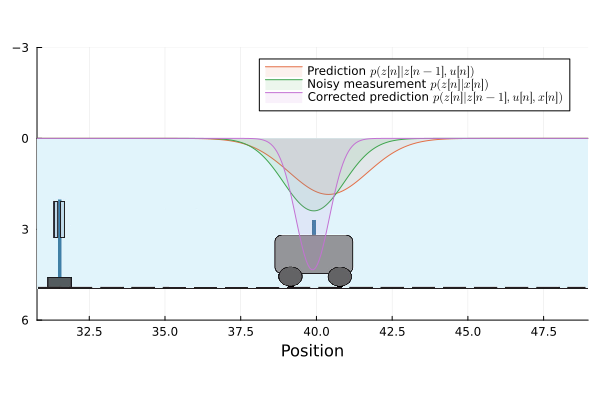

In [4]:
import RxInfer.ReactiveMP: messageout, getinterface, materialize!
import RxInfer.Rocket: getrecent

z_prev_m_0 = noisy_x[1]  
z_prev_v_0 = A * (1e8*Diagonal(I,2) * A') + Σz ;
result = inference(model=cart_tracking(n, A,b, Σz, Σx, z_prev_m_0, z_prev_v_0,u), data=(x=noisy_x,), free_energy=true);
μz_posterior, Σz_posterior = mean.(result.posteriors[:z])[end], cov.(result.posteriors[:z])[end];
prediction_z_1 =  messageout(getinterface(result.returnval[end][end], :out))
prediction = materialize!(getrecent(prediction_z_1));
println("Prediction: ",MvNormalMeanCovariance(mean(prediction), cov(prediction)))
println("Measurement: ", MvNormalMeanCovariance(noisy_x[n], Σx))
println("Posterior: ", MvNormalMeanCovariance(μz_posterior, Σz_posterior))
plotCartPrediction(mean(prediction)[1], cov(prediction)[1], μz_posterior[1], Σz_posterior[1], noisy_x[n][1], Σx[1][1])

- Note that both the analytical Kalman filtering solution and the message passing solution lead to the same results. The advantage of message passing-based inference with RxInfer is that we did not need to derive any inference equations. RxInfer took care of all that. 

### Recap Dynamical Models 

- Dynamical systems do not obey the sample-by-sample independence assumption, but still can be specified, and state and parameter estimation equations can be solved by similar tools as for static models.

- Two of the more famous and powerful models with latent states include the hidden Markov model (with discrete states) and the Linear Gaussian dynamical system (with continuous states).

- For the LGDS, the Kalman filter is a well-known recursive state estimation procedure. The Kalman filter can be derived through Bayesian update rules on Gaussian distributions. 

- If anything changes in the model, e.g., the state noise is not Gaussian, then you have to re-derive the inference equations again from scratch and it may not lead to an analytically pleasing answer. 

- $\Rightarrow$ Generally, we will want to automate the inference processes. As we discussed, message passing in a factor graph is a visually appealing method to automate inference processes. We showed how Kalman filtering emerged naturally by automated message passing. 

## <center> OPTIONAL SLIDES</center>

### Extensions of Generative Gaussian Models

- Using the methods of the previous lessons, it is possible to create your own new models based on stacking Gaussian and categorical distributions in new ways: 

<img src="./figures/fig-generative-Gaussian-models.png" width="600px">

In [4]:
open("../../styles/aipstyle.html") do f display("text/html", read(f, String)) end

<!--
This HTML file contains custom styles and some javascript.
Include it a Jupyter notebook for improved rendering.
-->

<!-- Fonts -->
 
 
 
 
 

<!-- Custom style -->


<!-- MathJax styling -->